In [1]:
import typing
from scipy.sparse import spmatrix, csr_matrix
from nptyping import NDArray, Shape
import torch
import torchvision
from scipy.spatial.distance import squareform
import numpy as np

In [2]:
from paradime.dissimilarity import NeighborBased
from paradime.transforms import PerplexityBased

In [3]:
mnist = torchvision.datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [4]:
testdata = mnist.data.reshape(-1, 28*28) / 255.
testdata = testdata[:5000]

In [22]:
diss = NeighborBased(90,
    verbose=True#,
    # transform=PerplexityBased(100, verbose=True)
)

In [23]:
foo = diss.compute_dissimilarities(testdata)

2022-06-09 14:55:07.6: Indexing nearest neighbors.


In [25]:
diss.dissimilarities.diss[1][59]

array([0.       , 1.7618757, 1.803555 , 2.1294081, 2.254322 , 2.5797842,
       2.5990653, 2.6930957, 2.725713 , 2.732613 , 2.7776446, 2.7978187,
       2.8240685, 2.868501 , 2.8943913, 2.9352202, 2.938697 , 3.0016272,
       3.006217 , 3.038034 , 3.0489962, 3.0714772, 3.094366 , 3.0971954,
       3.1039531, 3.1509092, 3.1743858, 3.2142224, 3.2251582, 3.2552493,
       3.277315 , 3.2804267, 3.2897778, 3.31383  , 3.3172483, 3.3271432,
       3.3332412, 3.347396 , 3.3629594, 3.3787653, 3.3823025, 3.413067 ,
       3.4203722, 3.4257028, 3.426751 , 3.4470968, 3.477598 , 3.4822757,
       3.4857318, 3.5337207, 3.5435207, 3.5614018, 3.5684206, 3.5750105,
       3.588244 , 3.5905168, 3.6100504, 3.6166751, 3.6625352, 3.6680508,
       3.678074 , 3.6998873, 3.7219303, 3.7521687, 3.7921772, 3.7960844,
       3.7967408, 3.8005688, 3.814733 , 3.8182085, 3.8189616, 3.828528 ,
       3.8316555, 3.8729596, 3.8740115, 3.8839252, 3.8992953, 3.899331 ,
       3.9016218, 3.9058154, 3.9067054, 3.9087477, 

In [13]:
import scipy
from numba import jit
from matplotlib import pyplot as plt

In [27]:
def p_i(dists, beta):

    x = - dists * beta
    y = np.exp(x)
    ysum = y.sum()

    return y / ysum

def find_beta(dists, perp, **kwargs):
    return scipy.optimize.root_scalar(
        lambda b: entropy(dists, b) - np.log2(perp),
        **kwargs
    ).root

@jit
def entropy(dists, beta):

    x = dists * beta
    y = np.exp(x)
    ysum = y.sum()

    if ysum < 1e-50:
        result = -1.
    else:
        factor = - 1/(np.log(2.) * ysum)
        result = factor * ((y * x) - (y * np.log(ysum))).sum()
    
    return result

In [34]:
ent = [ entropy(foo.diss[1][58, 1:], b) for b in np.arange(-2., 15., 0.1) ]

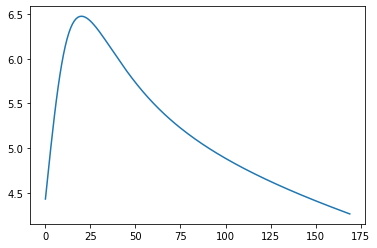

In [35]:
plt.plot(ent)

In [31]:
np.log2(100.)

6.643856189774724